In [41]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

## Define paths and read image from folder

In [2]:
TRAIN_DATA_PATH = "./DATASET/TRAIN/"
TEST_DATA_PATH = "./DATASET/TEST/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])
BATCH_SIZE = 64

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 


## Image shape

In [3]:
train_data[1][0].shape

torch.Size([3, 256, 256])

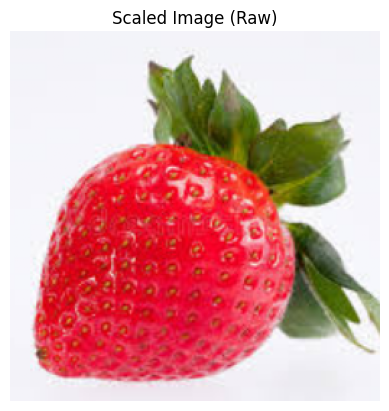

In [4]:
img_tensor = train_data[1][0]  # shape: (3, 256, 256) pytorch shape is Channel, Height, Width, but for imshow,
#it expects Height, Width,  Channels
img_np = img_tensor.permute(1, 2, 0).numpy()  # shape: (256, 256, 3)

plt.imshow(img_np, cmap='gray')
plt.title("Scaled Image (Raw)")
plt.axis('off')
plt.show()

In [5]:
train_data.classes

['O', 'R']

In [11]:
#O1643 not organic

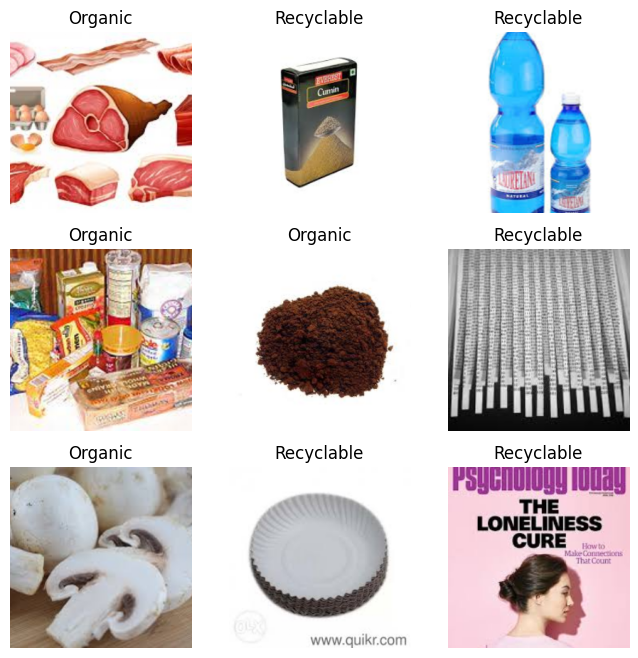

In [7]:
labels_map = {
    0: "Organic",
    1: "Recyclable"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label] )
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy().squeeze())
plt.show()

In [8]:
EPOCHS = 10

LEARNING_RATE = 0.001
MOMENTUM = 0.9

## Self defined CNN

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [13]:
train_data

Dataset ImageFolder
    Number of datapoints: 22564
    Root location: ./DATASET/TRAIN/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(256, 256))
               ToTensor()
           )

In [14]:
PRINT_INTERVAL = 5000
print_every = PRINT_INTERVAL // BATCH_SIZE
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    running_loss = 0.0
    total_samples = 0
    for i, data_i in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_i[0].to(device), data_i[1].to(device)
        labels = labels.view(-1, 1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_samples += inputs.size(0)
        
        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"[Epoch {epoch+1}, Sample {total_samples}] loss: {avg_loss:.4f}")
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Sample 4992] loss: 0.6791
[Epoch 1, Sample 9984] loss: 0.5665
[Epoch 1, Sample 14976] loss: 0.4643
[Epoch 1, Sample 19968] loss: 0.4785
[Epoch 2, Sample 4992] loss: 0.4587
[Epoch 2, Sample 9984] loss: 0.4517
[Epoch 2, Sample 14976] loss: 0.4395
[Epoch 2, Sample 19968] loss: 0.4496
[Epoch 3, Sample 4992] loss: 0.4391
[Epoch 3, Sample 9984] loss: 0.4371
[Epoch 3, Sample 14976] loss: 0.4243
[Epoch 3, Sample 19968] loss: 0.4449
[Epoch 4, Sample 4992] loss: 0.4410
[Epoch 4, Sample 9984] loss: 0.4242
[Epoch 4, Sample 14976] loss: 0.4389
[Epoch 4, Sample 19968] loss: 0.4221
[Epoch 5, Sample 4992] loss: 0.4365
[Epoch 5, Sample 9984] loss: 0.4182
[Epoch 5, Sample 14976] loss: 0.4203
[Epoch 5, Sample 19968] loss: 0.4268
[Epoch 6, Sample 4992] loss: 0.4261
[Epoch 6, Sample 9984] loss: 0.4182
[Epoch 6, Sample 14976] loss: 0.4189
[Epoch 6, Sample 19968] loss: 0.4177
[Epoch 7, Sample 4992] loss: 0.4173
[Epoch 7, Sample 9984] loss: 0.4248
[Epoch 7, Sample 14976] loss: 0.4214
[Epoch 7, Sampl

## Save weights

In [15]:
PATH = './waste_mgmt_self_defined.pth'
torch.save(net.state_dict(), PATH)

In [16]:
dataiter = iter(test_data_loader)
images, labels = next(dataiter)

In [17]:
images.shape

torch.Size([64, 3, 256, 256])

GroundTruth:  R     R     O     O     O     R     O     O     R     O     R     R     R     R     O     O     R     O     O     R     R     R     R     O     O     O     O     R     R     R     R     R     O     R     O     O     R     O     O     O     R     R     O     O     R     O     O     R     R     R     O     O     O     O     R     O     O     O     R     O     R     R     O     O    


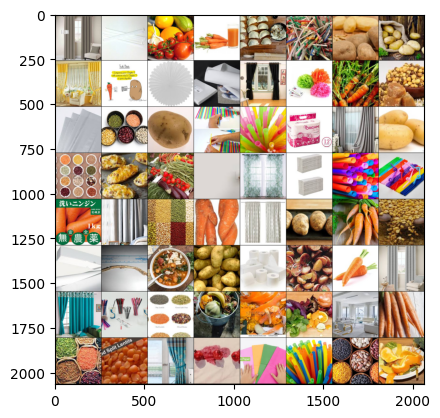

In [18]:
dataiter = iter(test_data_loader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{train_data.classes[labels[j]]:5s}' for j in range(len(labels))))

## Load weights

In [19]:
net_loaded = Net()
net_loaded.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [27]:
net_loaded.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [20]:
outputs = net_loaded(images)

In [21]:
outputs.shape

torch.Size([64, 1])

In [23]:
probs = torch.sigmoid(outputs)
predicted_classes = (probs >= 0.5).int()

In [24]:
print('Predicted: ', ' '.join(f'{train_data.classes[predicted_classes[j]]:5s}'
                              for j in range(64)))

Predicted:  R     R     O     O     O     O     O     O     O     O     R     R     R     O     O     O     R     O     O     R     O     R     R     O     O     O     O     R     R     R     O     R     O     R     O     O     R     O     O     O     R     R     O     O     R     O     O     R     R     R     O     O     O     O     R     O     O     O     R     R     O     O     O     O    


In [22]:
predicted_classes.shape

torch.Size([64, 1])

In [39]:
images.shape

torch.Size([64, 3, 256, 256])

In [25]:
classes = ('O', "R")

In [81]:
images.shape

torch.Size([64, 3, 256, 256])

In [71]:
labels

tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1])

In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data_i in test_data_loader:
        images, labels = data_i[0].to(device), data_i[1].to(device)
        labels = labels.view(-1, 1).float() 
        # calculate outputs by running images through the network
        outputs = net_loaded(images)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs >= 0.5).int() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2513 test images: 87 %


In [29]:
predicted.shape

torch.Size([17, 1])

In [30]:
labels.shape

torch.Size([17, 1])

In [31]:
predicted

tensor([[0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0]], device='cuda:0', dtype=torch.int32)

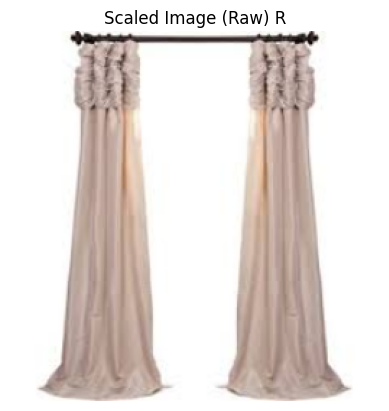

In [32]:
img_tensor = test_data[1500][0]  # shape: (3, 256, 256) pytorch shape is Channel, Height, Width, but for imshow,
#it expects Height, Width,  Channels
img_np = img_tensor.permute(1, 2, 0).numpy()  # shape: (256, 256, 3)

plt.imshow(img_np, cmap='gray')
plt.title(f"Scaled Image (Raw) {classes[test_data[1500][1]]}")
plt.axis('off')
plt.show()

In [34]:
img_tensor = test_data[1500][0].unsqueeze(0).to(device)
output = net_loaded(img_tensor)
prob = torch.sigmoid(output)
predicted_class = (prob >= 0.5).int().item()
print(f"Predicted class: {classes[predicted_class]}")

Predicted class: R


# Try using VGG16

In [35]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

C:\Users\zheng\anaconda3\envs\waste_mgmt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zheng\anaconda3\envs\waste_mgmt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [37]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# Change vgg out_features from 1000 to 1 (binary)
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)
vgg16 = vgg16.to(device)

In [39]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### VGG16 expects images of size 224×224 and normalized using ImageNet mean/std:

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])
BATCH_SIZE = 64

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

### Freeze previous layers

In [43]:
for param in vgg16.features.parameters():
    param.requires_grad = False

### Training loop

In [44]:
PRINT_INTERVAL = 5000
print_every = PRINT_INTERVAL // BATCH_SIZE
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    vgg16.train()
    running_loss = 0.0
    total_samples = 0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.view(-1, 1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_samples += inputs.size(0)
        
        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"[Epoch {epoch+1}, Sample {total_samples}] loss: {avg_loss:.4f}")
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Sample 4992] loss: 0.3058
[Epoch 1, Sample 9984] loss: 0.2087
[Epoch 1, Sample 14976] loss: 0.1919
[Epoch 1, Sample 19968] loss: 0.1742
[Epoch 2, Sample 4992] loss: 0.1595
[Epoch 2, Sample 9984] loss: 0.1484
[Epoch 2, Sample 14976] loss: 0.1513
[Epoch 2, Sample 19968] loss: 0.1388
[Epoch 3, Sample 4992] loss: 0.1323
[Epoch 3, Sample 9984] loss: 0.1247
[Epoch 3, Sample 14976] loss: 0.1250
[Epoch 3, Sample 19968] loss: 0.1204
[Epoch 4, Sample 4992] loss: 0.1026
[Epoch 4, Sample 9984] loss: 0.1082
[Epoch 4, Sample 14976] loss: 0.1031
[Epoch 4, Sample 19968] loss: 0.1091
[Epoch 5, Sample 4992] loss: 0.0971
[Epoch 5, Sample 9984] loss: 0.0973
[Epoch 5, Sample 14976] loss: 0.0869
[Epoch 5, Sample 19968] loss: 0.0926
[Epoch 6, Sample 4992] loss: 0.0718
[Epoch 6, Sample 9984] loss: 0.0743
[Epoch 6, Sample 14976] loss: 0.0798
[Epoch 6, Sample 19968] loss: 0.0794
[Epoch 7, Sample 4992] loss: 0.0665
[Epoch 7, Sample 9984] loss: 0.0703
[Epoch 7, Sample 14976] loss: 0.0619
[Epoch 7, Sampl

In [54]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data_i in test_data_loader:
        images, labels = data_i[0].to(device), data_i[1].to(device)
        labels = labels.view(-1, 1).float() 
        # calculate outputs by running images through the network
        outputs = vgg16(images)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs >= 0.5).int() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2513 test images: 91 %


In [46]:
correct

2294

# Save weights

In [47]:
PATH = './waste_mgmt_vgg.pth'
torch.save(vgg16.state_dict(), PATH)

In [48]:
vgg16_loaded = models.vgg16(pretrained=False)
vgg16_loaded.classifier[-1] = nn.Linear(4096,1)

vgg16_loaded.load_state_dict(torch.load(PATH, weights_only=True))

C:\Users\zheng\anaconda3\envs\waste_mgmt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [49]:
vgg16_loaded = vgg16_loaded.to(device)

In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data_i in test_data_loader:
        images, labels = data_i[0].to(device), data_i[1].to(device)
        labels = labels.view(-1, 1).float() 
        # calculate outputs by running images through the network
        outputs = vgg16_loaded(images)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs >= 0.5).int() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2513 test images: 91 %


In [51]:
correct

2300

In [70]:
total

2513